# Urban vs. Rural Population Analysis: Impact on Life Expectancy

In [47]:
# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import hvplot.pandas

# Study data files
country_data_path = "Data/health_data.csv"
doctors_data_path = "Data/Medical_doctors.csv"
population_data_path = "Data/population.csv"

# Read the country, population and doctor data
country_data = pd.read_csv(country_data_path)
doctors_data = pd.read_csv(doctors_data_path)
population_data = pd.read_csv(population_data_path)

## Data Cleaning

### Understand the data - Pre-cleaning

In [48]:
# Check "health_data" dataset info
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9928 entries, 0 to 9927
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country                                  9928 non-null   object 
 1   Year                                     9928 non-null   int64  
 2   Gender                                   9928 non-null   object 
 3   Life expectancy                          9928 non-null   float64
 4   Unemployment                             9928 non-null   float64
 5   Infant Mortality                         9928 non-null   float64
 6   GDP                                      9928 non-null   float64
 7   GNI                                      9928 non-null   float64
 8   Clean fuels and cooking technologies     9928 non-null   float64
 9   Per Capita                               9928 non-null   float64
 10  Mortality caused by road traffic injury  9928 no

In [49]:
# Check "Medical_doctors" dataset info
doctors_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3583 entries, 0 to 3582
Data columns (total 7 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Country                                       3583 non-null   object 
 1   Year                                          3583 non-null   int64  
 2   Medical doctors (per 10 000 population)       2844 non-null   float64
 3   Medical doctors (number)                      3410 non-null   float64
 4   Generalist medical practitioners (number)     1279 non-null   float64
 5   Specialist medical practitioners (number)     1195 non-null   float64
 6   Medical doctors not further defined (number)  2780 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 196.1+ KB


In [50]:
# Check "population" dataset info
population_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            265 non-null    float64
 5   1961            265 non-null    float64
 6   1962            265 non-null    float64
 7   1963            265 non-null    float64
 8   1964            265 non-null    float64
 9   1965            265 non-null    float64
 10  1966            265 non-null    float64
 11  1967            265 non-null    float64
 12  1968            265 non-null    float64
 13  1969            265 non-null    float64
 14  1970            265 non-null    float64
 15  1971            265 non-null    float64
 16  1972            265 non-null    float64
 17  1973            265 non-null    flo

In [51]:
# Compare countries and years present in 2 datasets.
print(f"Number of countries in the health_data file is {country_data['Country'].nunique()}")
print(f"Number of countries in the Medical_doctors file is {doctors_data['Country'].nunique()}")
print(f"Number of years in the health_data file is {country_data['Year'].nunique()}, the earliest is {country_data['Year'].min()}, the latest is {country_data['Year'].max()}")
print(f"Number of years in the Medical_doctors file is {doctors_data['Year'].nunique()}, the earliest is {doctors_data['Year'].min()}, the latest is {doctors_data['Year'].max()}")
print(f"\nNumber of Male and Female rows:\n{country_data.groupby('Gender').size()}")

Number of countries in the health_data file is 256
Number of countries in the Medical_doctors file is 196
Number of years in the health_data file is 20, the earliest is 2000, the latest is 2019
Number of years in the Medical_doctors file is 69, the earliest is 1952, the latest is 2020

Number of Male and Female rows:
Gender
Female    4964
Male      4964
dtype: int64


### Clean the data

In [52]:
# Define list of the years to be included into the analysis
first_year = 2015
last_year = 2019
years_list = list(range(first_year,last_year+1, 1))

years_list

[2015, 2016, 2017, 2018, 2019]

#### Clean "population" dataset

In [53]:
# Remove unnecessary columns
population_data_reduced = population_data.drop(columns=['Country Code','Indicator Name','Indicator Code'])

# Rename column Country Name to align with other datasets
population_data_reduced.rename(columns={'Country Name': 'Country'}, inplace=True)

# Transpose years into columns
population_data_reduced = pd.melt(population_data_reduced, id_vars=['Country'], 
                                var_name= 'Year', value_name='Population, female (percent of total)')

# Change Year values into integer
population_data_reduced['Year'] = population_data_reduced['Year'].astype(int)

# Filter on years
population_data_recent = population_data_reduced[population_data_reduced["Year"].isin(years_list)].reset_index(drop=True)

population_data_recent

,Country,Year,"Population, female (percent of total)"
0,Aruba,2015,52.589275
1,Africa Eastern and Southern,2015,50.531940
2,Afghanistan,2015,49.423184
3,Africa Western and Central,2015,49.796591
4,Angola,2015,50.657496
...,...,...,...
1325,Kosovo,2019,50.127604
1326,"Yemen, Rep.",2019,49.428680
1327,South Africa,2019,51.438495
1328,Zambia,2019,50.673761


#### Clean country level "health_data" dataset:

In [54]:
# Remove unnecessary columns
country_data_reduced = country_data.drop(columns=['Unemployment',
                                                'Infant Mortality',
                                                'GNI',
                                                'Clean fuels and cooking technologies',
                                                'Mortality caused by road traffic injury',
                                                'Tuberculosis Incidence',
                                                'Tuberculosis treatment',
                                                'Non-communicable Mortality',
                                                'Sucide Rate'
                                                ]
                                        )

# Filter on years
country_data_recent = country_data_reduced[country_data_reduced["Year"].isin(years_list)]

# Remove duplicated rows (if any)
country_data_recent.drop_duplicates(["Country","Year","Gender"])

# Identify countries that do not have all the records for 5 years
countries_missing_year = country_data_recent.groupby("Country").filter(lambda x: len(x) <
                                                     (last_year - first_year+1)*2)["Country"].unique()

# Print list of the countriest that are excluded from the analysis due to the missing information
print(f"{countries_missing_year} were removed from the analysis,\n because of incomplete information in column 'Year'.")

# Remove countries that do not have all the records for 5 years
country_data_recent = country_data_recent[~country_data_recent["Country"].isin(countries_missing_year)]

country_data_recent

['Curacao' 'Greenland' 'Sint Maarten (Dutch part)'] were removed from the analysis,
 because of incomplete information in column 'Year'.


,Country,Year,Gender,Life expectancy,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population
15,Afghanistan,2015,Female,64.877,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197
16,Afghanistan,2016,Female,65.275,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980
17,Afghanistan,2017,Female,65.656,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750
18,Afghanistan,2018,Female,66.026,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505
19,Afghanistan,2019,Female,66.388,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9923,Zimbabwe,2015,Male,57.778,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615
9924,Zimbabwe,2016,Male,58.565,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704
9925,Zimbabwe,2017,Male,59.105,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763
9926,Zimbabwe,2018,Male,59.501,1.811554e+10,1254.642265,89.0,89.0,88.0,2.350000,36.357160,32.209,67.791


#### Merge population and health_data datasets

In [55]:
# Merge country "health_data" and "population" datasets:
country_population = pd.merge(country_data_recent, population_data_recent, on= ["Country", "Year"], how="left")

country_population

,Country,Year,Gender,Life expectancy,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)"
0,Afghanistan,2015,Female,64.877,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184
1,Afghanistan,2016,Female,65.275,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608
2,Afghanistan,2017,Female,65.656,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284
3,Afghanistan,2018,Female,66.026,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209
4,Afghanistan,2019,Female,66.388,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Zimbabwe,2015,Male,57.778,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890
2456,Zimbabwe,2016,Male,58.565,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111
2457,Zimbabwe,2017,Male,59.105,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393
2458,Zimbabwe,2018,Male,59.501,1.811554e+10,1254.642265,89.0,89.0,88.0,2.350000,36.357160,32.209,67.791,52.923755


In [56]:
# Check info about new merged Data frame to confirm if there are missing values in the column Population Female %.
country_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Country                                2460 non-null   object 
 1   Year                                   2460 non-null   int64  
 2   Gender                                 2460 non-null   object 
 3   Life expectancy                        2460 non-null   float64
 4   GDP                                    2460 non-null   float64
 5   Per Capita                             2460 non-null   float64
 6   DPT Immunization                       2460 non-null   float64
 7   HepB3 Immunization                     2460 non-null   float64
 8   Measles Immunization                   2460 non-null   float64
 9   Hospital beds                          2460 non-null   float64
 10  Basic sanitation services              2460 non-null   float64
 11  Urba

In [57]:
# List Countries/Years that do not have Population, female (percent of total) data
country_no_ratio = country_population[
    country_population['Population, female (percent of total)'].isnull()]['Country'].unique()

print (f'Countries, with no information on Male/Female population ratio: {country_no_ratio},\n assumption applied that Male/Female ratio is 50%')

Countries, with no information on Male/Female population ratio: ['Czech Republic' 'Turkey'],
 assumption applied that Male/Female ratio is 50%


In [58]:
# Replace missing values in the Population, female (percent of total) Column with 50%.
country_population['Population, female (percent of total)'].fillna(50, inplace=True)
country_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2460 entries, 0 to 2459
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Country                                2460 non-null   object 
 1   Year                                   2460 non-null   int64  
 2   Gender                                 2460 non-null   object 
 3   Life expectancy                        2460 non-null   float64
 4   GDP                                    2460 non-null   float64
 5   Per Capita                             2460 non-null   float64
 6   DPT Immunization                       2460 non-null   float64
 7   HepB3 Immunization                     2460 non-null   float64
 8   Measles Immunization                   2460 non-null   float64
 9   Hospital beds                          2460 non-null   float64
 10  Basic sanitation services              2460 non-null   float64
 11  Urba

#### Clean "Medical_doctors" dataset:


In [59]:
# Remove unnecessary columns
doctors_data_reduced = doctors_data.drop(columns=['Medical doctors (per 10 000 population)',
                                                'Generalist medical practitioners (number)',
                                                'Specialist medical practitioners (number)',
                                                'Medical doctors not further defined (number)',
                                                ]
                                        )

# Filter on years
doctors_data_recent = doctors_data_reduced[doctors_data_reduced["Year"].isin(years_list)]

doctors_data_recent

,Country,Year,Medical doctors (number)
1,Afghanistan,2019,8082.0
2,Afghanistan,2018,11026.0
3,Afghanistan,2017,8744.0
4,Afghanistan,2016,9842.0
5,Afghanistan,2015,9808.0
...,...,...,...
3557,Zambia,2016,1514.0
3565,Zimbabwe,2018,3026.0
3566,Zimbabwe,2017,2646.0
3567,Zimbabwe,2016,2508.0


### Create combined Data Frame 

#### Create and clean dataset broken down by Gender

In [60]:
# Combine everything into a single DataFrame
country_doctors_fm = pd.merge(country_population,doctors_data_recent, on= ["Country", "Year"], how= "left")

country_doctors_fm

,Country,Year,Gender,Life expectancy,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number)
0,Afghanistan,2015,Female,64.877,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0
1,Afghanistan,2016,Female,65.275,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0
2,Afghanistan,2017,Female,65.656,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0
3,Afghanistan,2018,Female,66.026,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0
4,Afghanistan,2019,Female,66.388,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Zimbabwe,2015,Male,57.778,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0
2456,Zimbabwe,2016,Male,58.565,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0
2457,Zimbabwe,2017,Male,59.105,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0
2458,Zimbabwe,2018,Male,59.501,1.811554e+10,1254.642265,89.0,89.0,88.0,2.350000,36.357160,32.209,67.791,52.923755,3026.0


In [61]:
# Remove rows without Medical doctors (number) information
country_doctors_fm_filtered = country_doctors_fm.dropna(subset=["Medical doctors (number)"]).reset_index(drop=True)

country_doctors_fm_filtered

,Country,Year,Gender,Life expectancy,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number)
0,Afghanistan,2015,Female,64.877,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0
1,Afghanistan,2016,Female,65.275,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0
2,Afghanistan,2017,Female,65.656,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0
3,Afghanistan,2018,Female,66.026,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0
4,Afghanistan,2019,Female,66.388,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Zambia,2018,Male,60.533,2.631159e+10,1516.368371,90.0,90.0,94.0,1.966667,31.052407,43.521,56.479,50.690913,2026.0
982,Zimbabwe,2015,Male,57.778,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0
983,Zimbabwe,2016,Male,58.565,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0
984,Zimbabwe,2017,Male,59.105,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0


#### Create and clean dataset for total population (without divison between Female and Male):

In [62]:
# Create a full list of countries (from the main "health_data" file)
countries_list = country_doctors_fm["Country"].unique().tolist()

# Create a list of columns to compare Male/Female values
columns_list = country_doctors_fm.columns.tolist()
excluded_columns = ["Country","Year","Gender", "Population, female (percent of total)", "Medical doctors (number)"]
columns_to_compare = [x for x in columns_list if x not in excluded_columns]

# Creat lists to store column names for columns with equal values for Female and Male across one country/year and columns with diffrenet values
equal_column_list = []
non_equal_column_list = []

# Check which columns values are different for Male and Female, and which ones are the same. 
# Loop through countries
for country in countries_list:
    # Loop throught years
    for year in years_list:
        female_row = (country_doctors_fm["Country"] == country) & (country_doctors_fm["Year"] == year) & (country_doctors_fm["Gender"] == "Female")
        male_row = (country_doctors_fm["Country"] == country) & (country_doctors_fm["Year"] == year) & (country_doctors_fm["Gender"] == "Male")
        # Loop through columns
        for column in columns_to_compare:
            female_value = country_doctors_fm.loc[female_row, column].values[0]
            male_value = country_doctors_fm.loc[male_row, column].values[0]
      
            # Compare values across columns for Female and Male:
            if female_value == male_value:
                # Create a list of columns where Male/Female information is the same across a country and a year.
                equal_column_list.append(column)
            else:
                # Create a list of columns where Male/Female information varies.
                non_equal_column_list.append(column)
          
equal_unique = list(set(equal_column_list))
non_equal_unique = list(set(non_equal_column_list))

print(f"Columns with different values for Male and Female: {non_equal_unique}")
print(f"Columns with repeating values for Male and Female: {equal_unique}")

Columns with different values for Male and Female: ['Life expectancy']
Columns with repeating values for Male and Female: ['GDP', 'DPT Immunization', 'Basic sanitation services', 'Urban population', 'Per Capita', 'Rural population', 'Measles Immunization', 'HepB3 Immunization', 'Hospital beds']


In [63]:
# Create a new table for total values.
# Filter original data frame by keeping column with differnet values for Male and Female ("Life Expectancy") and "identifyer" columns - "Country", "Year", "Gender".
columns_to_drop = equal_unique + ["Medical doctors (number)"]
country_doctors_fm_reduced = country_doctors_fm.drop(columns=columns_to_drop)

# Transpose 'Gender' column into 'Female' and 'Male' columns
country_doctors_transposed = country_doctors_fm_reduced.pivot(index=["Country","Year"],columns=["Gender"], values=["Life expectancy","Population, female (percent of total)"]).reset_index()

# Flatten the column index of country_doctors_transposed_reduced DataFrame
country_doctors_transposed.columns = country_doctors_transposed.columns.map(''.join)

# Add column to calculate Life expectancy for the entire population (weighted average)
country_doctors_transposed["Life expectancy total population"] = (country_doctors_transposed["Life expectancyFemale"] * 
                                                                country_doctors_transposed["Population, female (percent of total)Female"]/100 + 
                                                                country_doctors_transposed["Life expectancyMale"] * 
                                                                (100 - country_doctors_transposed["Population, female (percent of total)Female"])/100
                                                                )

# Drop unimportant columns for the further merging steps
country_doctors_transposed_reduced = country_doctors_transposed.drop(columns=[("Life expectancyFemale"), 
                                                                            ("Life expectancyMale"), 
                                                                            ("Population, female (percent of total)Female"),
                                                                            ("Population, female (percent of total)Male")
                                                                            ]
                                                                    )

# Merge with country_doctors_fm dataframe to have all the information available.
country_doctors_total_merged = pd.merge(country_doctors_fm,country_doctors_transposed_reduced, on= ["Country","Year"], how= "left")

# Drop unimportant columns
country_doctors_total = country_doctors_total_merged.drop(columns=["Gender","Life expectancy"])

# Remove duplicated rows
country_doctors_total = country_doctors_total.drop_duplicates(["Country","Year"])

country_doctors_total

,Country,Year,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,2015,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0,63.404203
1,Afghanistan,2016,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0,63.791836
2,Afghanistan,2017,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0,64.161340
3,Afghanistan,2018,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0,64.519734
4,Afghanistan,2019,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0,64.868632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,Zimbabwe,2015,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0,59.477176
1226,Zimbabwe,2016,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0,60.235772
1227,Zimbabwe,2017,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0,60.754342
1228,Zimbabwe,2018,1.811554e+10,1254.642265,89.0,89.0,88.0,2.350000,36.357160,32.209,67.791,52.923755,3026.0,61.140049


In [64]:
# Remove rows without "Medical doctors (number)" information.
country_doctors_total_filtered = country_doctors_total.dropna(subset=["Medical doctors (number)"]).reset_index(drop=True)

country_doctors_total_filtered

,Country,Year,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,2015,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0,63.404203
1,Afghanistan,2016,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0,63.791836
2,Afghanistan,2017,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0,64.161340
3,Afghanistan,2018,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0,64.519734
4,Afghanistan,2019,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0,64.868632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Zambia,2018,2.631159e+10,1516.368371,90.0,90.0,94.0,1.966667,31.052407,43.521,56.479,50.690913,2026.0,63.530861
489,Zimbabwe,2015,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0,59.477176
490,Zimbabwe,2016,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0,60.235772
491,Zimbabwe,2017,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0,60.754342


#### Create dataset with averaged out information across different years for a country

In [65]:
# Average out the values across analyzed years for one country
country_doctors_total_avg = country_doctors_total.groupby("Country").mean()

# Reset index
country_doctors_total_avg = country_doctors_total_avg.reset_index()

# Drop column Year
country_doctors_total_avg = country_doctors_total_avg.drop(columns="Year")

country_doctors_total_avg

,Country,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,1.857138e+10,512.909526,65.800000,65.800000,63.800000,0.450889,45.802640,25.264400,74.735600,49.429954,9500.4,64.149149
1,Africa Eastern and Southern,9.602807e+11,1531.783575,76.801024,76.422452,72.968797,0.911871,29.998931,35.340330,64.659670,50.513523,NaN,63.214975
2,Africa Western and Central,7.342557e+11,1732.735510,66.188590,66.177998,63.048121,2.986346,33.227307,46.015701,53.984299,49.771207,NaN,57.355333
3,Albania,1.336488e+10,4658.240106,98.800000,98.800000,95.600000,3.052308,98.493376,59.357200,40.642800,49.884581,4826.0,78.355262
4,Algeria,1.685577e+11,4073.145408,91.800000,91.800000,87.400000,1.820000,86.449686,72.035400,27.964600,49.045001,73456.5,76.491339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,West Bank and Gaza,1.578318e+10,3527.863570,85.685266,81.307785,84.854727,2.986346,97.165781,75.898800,24.101200,50.202434,NaN,73.786391
242,World,8.128929e+13,10806.022309,85.545898,83.760753,85.351016,2.766197,74.929771,54.823002,45.176998,49.681628,NaN,72.429675
243,"Yemen, Rep.",2.939171e+10,1106.402264,69.200000,69.200000,66.600000,0.692889,52.607593,36.020400,63.979600,49.391027,NaN,66.088948
244,Zambia,2.354070e+10,1395.132689,90.600000,90.600000,93.200000,1.966667,30.604350,42.982800,57.017200,50.714809,1770.0,62.942619


In [66]:
# 1st option - Remove rows without "Medical doctors (number)" information.
country_doctors_total_avg_filtered = country_doctors_total_avg.dropna(subset=["Medical doctors (number)"]).reset_index(drop= True)

country_doctors_total_avg_filtered

,Country,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,1.857138e+10,512.909526,65.8,65.8,63.8,0.450889,45.802640,25.2644,74.7356,49.429954,9500.4,64.149149
1,Albania,1.336488e+10,4658.240106,98.8,98.8,95.6,3.052308,98.493376,59.3572,40.6428,49.884581,4826.0,78.355262
2,Algeria,1.685577e+11,4073.145408,91.8,91.8,87.4,1.820000,86.449686,72.0354,27.9646,49.045001,73456.5,76.491339
3,Angola,1.060423e+11,3573.626620,58.8,54.8,47.8,0.800000,49.678755,64.8250,35.1750,50.627161,6496.5,60.446212
4,Antigua and Barbuda,1.506947e+09,15784.778096,95.2,96.0,93.4,2.934250,86.711731,24.7328,75.2672,52.309463,264.0,76.772637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,United Arab Emirates,3.880432e+11,40798.165271,98.6,98.6,99.0,1.435556,98.873917,86.2396,13.7604,29.497255,23108.4,77.560149
146,Uruguay,6.009822e+10,17482.429717,93.6,93.6,96.0,2.435667,97.191354,95.2378,4.7622,51.650642,15260.5,77.648019
147,Vanuatu,8.482107e+08,2965.101870,84.2,84.2,79.0,3.150000,52.959592,25.1708,74.8292,49.659382,46.0,70.252099
148,Zambia,2.354070e+10,1395.132689,90.6,90.6,93.2,1.966667,30.604350,42.9828,57.0172,50.714809,1770.0,62.942619


In [67]:
# 2nd option - Average out the values across analyzed years for one country.
# Average out the values across analyzed years for one country
country_doctors_total_avg_filtered_v2 = country_doctors_total_filtered.groupby("Country").mean()

# Reset index
country_doctors_total_avg_filtered_v2 = country_doctors_total_avg_filtered_v2.reset_index()

# Drop column Year
country_doctors_total_avg_filtered_v2 = country_doctors_total_avg_filtered_v2.drop(columns="Year")

country_doctors_total_avg_filtered_v2

,Country,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,1.857138e+10,512.909526,65.800000,65.800000,63.80,0.450889,45.802640,25.264400,74.735600,49.429954,9500.4,64.149149
1,Albania,1.413929e+10,4935.792872,98.666667,98.666667,95.00,3.052308,98.754871,59.989667,40.010333,49.900654,4826.0,78.441996
2,Algeria,1.674725e+11,4044.235503,91.000000,91.000000,87.00,1.800000,86.454289,72.044000,27.956000,49.044808,73456.5,76.494573
3,Angola,1.117385e+11,3692.727026,59.500000,55.500000,46.00,0.800000,50.498862,65.176500,34.823500,50.618667,6496.5,60.699323
4,Antigua and Barbuda,1.467978e+09,15383.576398,95.000000,95.000000,99.00,2.890000,87.504282,24.713000,75.287000,52.303032,264.0,76.773970
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,United Arab Emirates,3.880432e+11,40798.165271,98.600000,98.600000,99.00,1.435556,98.873917,86.239600,13.760400,29.497255,23108.4,77.560149
146,Uruguay,6.073531e+10,17703.263657,94.000000,94.000000,95.50,2.455000,97.047649,95.192000,4.808000,51.661990,15260.5,77.578703
147,Vanuatu,7.808896e+08,2805.665320,81.000000,81.000000,84.00,3.150000,53.148221,25.062000,74.938000,49.645856,46.0,70.097915
148,Zambia,2.363500e+10,1398.587457,90.500000,90.500000,93.50,1.966667,30.609018,42.979500,57.020500,50.713450,1770.0,63.001813


## Cleaned Datasets Overview and Limitations

1. Years included in the anaysis: 2015 to 2019

2. Countries that did not have Life Expectancy and Immunization Rates data for all 5 years were excluded from the analysis:
* Curacao, 
* Greenland, 
* Sint Maarten (Dutch part).

3. Countries that did not have Male/Female ratio were assigned 50% ratio to calculate Life Expectancy for the entire population (the information for these countries was missing for all 5 years):
* Czech Republic, 
* Turkey.

4. 60.98% of the countries were filtered out from the original data set because of the missing values for # of Medical Doctors to create _filtered data frames. _filtered data frames have 150 countries present.

5. 95 countries (63.33%) do not have complete information in column 'Year' in the _filtered data frames.

6. Available Data Frames overview (# of countries, # of rows):

Data frame by country by year (country_doctors_total) has 246 countries, and 1230 rows of data.
Data frame country_doctors_total_filtered has 150 countries, and 493 rows of data. 

Data frame by country with averaged inormation across the analyzed years (country_doctors_total_avg) has 246 countries, and 246 rows of data.
Data frame country_doctors_total_avg_filtered has 150 countries, and 150 rows of data. 

In [68]:
# Data Frames overview
print(f"\033[1mAvailable Data Frames overview:\033[0m")
print(f"\nData frame country_doctors_fm has {country_doctors_fm['Country'].nunique()} countries, and {country_doctors_fm.shape[0]} rows of data.")
print(f"Data frame country_doctors_fm_filtered has {country_doctors_fm_filtered['Country'].nunique()} countries, "
      f"and {country_doctors_fm_filtered.shape[0]} rows of data. "
      )
print(f"\nData frame country_doctors_total has {country_doctors_total['Country'].nunique()} countries, and {country_doctors_total.shape[0]} rows of data.")
print(f"Data frame country_doctors_total_filtered has {country_doctors_total_filtered['Country'].nunique()} countries, "
      f"and {country_doctors_total_filtered.shape[0]} rows of data. "
      )
print(f"\nData frame country_doctors_total_avg has {country_doctors_total_avg['Country'].nunique()} countries, and {country_doctors_total_avg.shape[0]} rows of data.")
print(f"Data frame country_doctors_total_avg_filtered has {country_doctors_total_avg_filtered['Country'].nunique()} countries, "
      f"and {country_doctors_total_avg_filtered.shape[0]} rows of data. "
      )
print(f"\n{round(country_doctors_fm_filtered['Country'].nunique()/country_doctors_fm['Country'].nunique()*100,2)}% "
      f"of the countries were \033[4mfiltered out\033[0m from the original data set \nbecause of the missing values for # of Medical Doctors to create _filtered data frames."
      )

Available Data Frames overview:

Data frame country_doctors_fm has 246 countries, and 2460 rows of data.
Data frame country_doctors_fm_filtered has 150 countries, and 986 rows of data. 

Data frame country_doctors_total has 246 countries, and 1230 rows of data.
Data frame country_doctors_total_filtered has 150 countries, and 493 rows of data. 

Data frame country_doctors_total_avg has 246 countries, and 246 rows of data.
Data frame country_doctors_total_avg_filtered has 150 countries, and 150 rows of data. 

60.98% of the countries were filtered out from the original data set 
because of the missing values for # of Medical Doctors to create _filtered data frames.


In [69]:
# List countries that did not have all 5 year's info after filtering based on the Medical doctors missing values. 
# Identify countries that do not have all the records for 5 years
filtered_countries_missing_year = country_doctors_total_filtered.groupby("Country").filter(lambda x: len(x) <
                                                     (last_year - first_year+1))["Country"].unique()

# Print list of the countriest that are excluded from the analysis due to the missing information
print(f"{len(filtered_countries_missing_year)} countries "
    f"({round(len(filtered_countries_missing_year)/country_doctors_total_filtered['Country'].nunique()*100,2)}%) "
    f"do not have complete information in column 'Year' in the _filtered data frames.\n {filtered_countries_missing_year}")

95 countries (63.33%) do not have complete information in column 'Year' in the _filtered data frames.
 ['Albania' 'Algeria' 'Angola' 'Antigua and Barbuda' 'Argentina' 'Armenia'
 'Bahrain' 'Barbados' 'Belize' 'Benin' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burundi' 'Cabo Verde' 'Cameroon'
 'Canada' 'Central African Republic' 'Comoros' 'Costa Rica' 'Cuba'
 'Denmark' 'Dominican Republic' 'Ecuador' 'El Salvador'
 'Equatorial Guinea' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'Gabon'
 'Grenada' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'India' 'Indonesia' 'Iraq' 'Jamaica' 'Japan' 'Jordan' 'Kenya'
 'Kuwait' 'Lesotho' 'Liberia' 'Libya' 'Luxembourg' 'Madagascar' 'Malawi'
 'Maldives' 'Mali' 'Malta' 'Mauritania' 'Mongolia' 'Morocco' 'Mozambique'
 'Myanmar' 'Namibia' 'Nepal' 'Nicaragua' 'Nigeria' 'North Macedonia'
 'Papua New Guinea' 'Paraguay' 'Peru' 'Philippines' 'Poland' 'Qatar'
 'Romania' 'Samoa' 'Sao Tome and Principe' 'Saudi Arabia' 

In [70]:
# Print the header
print(f"Countries with missing years in the _filtered Data Frames:")

# Return and print countries that do not have full 5 years of data present in the _filtered list.
filtered_years_list = country_doctors_total_filtered.pivot(index="Country",columns="Year", values="Year").reset_index()
filtered_years_list = filtered_years_list.fillna("")
filtered_year_missing = filtered_years_list[filtered_years_list["Country"].isin(filtered_countries_missing_year)].reset_index(drop=True)

# Print the results
pd.set_option('display.max_rows', None)
filtered_year_missing

Countries with missing years in the _filtered Data Frames:


Year,Country,2015,2016,2017,2018,2019
0,Albania,,2016.0,,2018.0,2019.0
1,Algeria,,2016.0,,2018.0,
2,Angola,,,2017.0,2018.0,
3,Antigua and Barbuda,,,2017.0,,
4,Argentina,2015.0,2016.0,2017.0,,2019.0
5,Armenia,2015.0,,2017.0,,
6,Bahrain,2015.0,,,,
7,Barbados,,,2017.0,,
8,Belize,,,2017.0,2018.0,
9,Benin,,2016.0,,2018.0,2019.0


In [71]:
# Print the header
print(f"Countries with all the years in the _filtered Data Frames:")

# Return and print countries that do not have full 5 years of data present in the _filtered list.
filtered_years_list = country_doctors_total_filtered.pivot(index="Country",columns="Year", values="Year").reset_index()
filtered_years_list = filtered_years_list.fillna("")
filtered_year_present = filtered_years_list[~filtered_years_list["Country"].isin(filtered_countries_missing_year)].reset_index(drop=True)

# Print the results
pd.set_option('display.max_rows', None)
filtered_year_present

Countries with all the years in the _filtered Data Frames:


Year,Country,2015,2016,2017,2018,2019
0,Afghanistan,2015.0,2016.0,2017.0,2018.0,2019.0
1,Australia,2015.0,2016.0,2017.0,2018.0,2019.0
2,Austria,2015.0,2016.0,2017.0,2018.0,2019.0
3,Azerbaijan,2015.0,2016.0,2017.0,2018.0,2019.0
4,Bangladesh,2015.0,2016.0,2017.0,2018.0,2019.0
5,Belarus,2015.0,2016.0,2017.0,2018.0,2019.0
6,Belgium,2015.0,2016.0,2017.0,2018.0,2019.0
7,Bhutan,2015.0,2016.0,2017.0,2018.0,2019.0
8,Burkina Faso,2015.0,2016.0,2017.0,2018.0,2019.0
9,Chad,2015.0,2016.0,2017.0,2018.0,2019.0


In [72]:
# Revert displaying of truncated view
pd.set_option('display.max_rows',10)

## Available Data Frames list:
- country_doctors_fm - Data Frame that contains information for Male/Female for all the countries/years.
- country_doctors_fm_filtered - Data Frame that contains filtered information for Male/Female - rows with null values in the column "Medical Doctors" (number) are filtered out.
- country_doctors_total - Data Frame that contains information for the whole population for all the countries/years.
- country_doctors_total_filtered - Data Frame that contains filtered information for the whole population, rows with null values in the column "Medical Doctors" (number) are filtered out.
- country_doctors_total_avg - Data Frame that contains information for the whole population for all the countries that is averaged out by years.
- country_doctors_total_avg_filtered - Data Frame that contains information for the whole population for all the countries that is averaged out by years, rows with null values in the column "Medical Doctors" (number) are filtered out.

For each Data Frame structure see below:

In [73]:
country_doctors_fm

,Country,Year,Gender,Life expectancy,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number)
0,Afghanistan,2015,Female,64.877,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0
1,Afghanistan,2016,Female,65.275,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0
2,Afghanistan,2017,Female,65.656,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0
3,Afghanistan,2018,Female,66.026,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0
4,Afghanistan,2019,Female,66.388,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,Zimbabwe,2015,Male,57.778,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0
2456,Zimbabwe,2016,Male,58.565,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0
2457,Zimbabwe,2017,Male,59.105,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0
2458,Zimbabwe,2018,Male,59.501,1.811554e+10,1254.642265,89.0,89.0,88.0,2.350000,36.357160,32.209,67.791,52.923755,3026.0


In [74]:
country_doctors_fm_filtered

,Country,Year,Gender,Life expectancy,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number)
0,Afghanistan,2015,Female,64.877,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0
1,Afghanistan,2016,Female,65.275,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0
2,Afghanistan,2017,Female,65.656,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0
3,Afghanistan,2018,Female,66.026,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0
4,Afghanistan,2019,Female,66.388,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Zambia,2018,Male,60.533,2.631159e+10,1516.368371,90.0,90.0,94.0,1.966667,31.052407,43.521,56.479,50.690913,2026.0
982,Zimbabwe,2015,Male,57.778,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0
983,Zimbabwe,2016,Male,58.565,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0
984,Zimbabwe,2017,Male,59.105,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0


In [75]:
country_doctors_total

,Country,Year,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,2015,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0,63.404203
1,Afghanistan,2016,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0,63.791836
2,Afghanistan,2017,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0,64.161340
3,Afghanistan,2018,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0,64.519734
4,Afghanistan,2019,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0,64.868632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,Zimbabwe,2015,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0,59.477176
1226,Zimbabwe,2016,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0,60.235772
1227,Zimbabwe,2017,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0,60.754342
1228,Zimbabwe,2018,1.811554e+10,1254.642265,89.0,89.0,88.0,2.350000,36.357160,32.209,67.791,52.923755,3026.0,61.140049


In [76]:
country_doctors_total_filtered

,Country,Year,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,2015,1.913421e+10,556.007221,65.0,65.0,63.0,0.500000,42.626023,24.803,75.197,49.423184,9808.0,63.404203
1,Afghanistan,2016,1.811656e+10,512.012778,66.0,66.0,64.0,0.500000,44.201217,25.020,74.980,49.414608,9842.0,63.791836
2,Afghanistan,2017,1.875347e+10,516.679862,66.0,66.0,64.0,0.390000,45.789127,25.250,74.750,49.419284,8744.0,64.161340
3,Afghanistan,2018,1.805323e+10,485.668419,66.0,66.0,64.0,0.432222,47.390662,25.495,74.505,49.437209,11026.0,64.519734
4,Afghanistan,2019,1.879945e+10,494.179350,66.0,66.0,64.0,0.432222,49.006170,25.754,74.246,49.455485,8082.0,64.868632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,Zambia,2018,2.631159e+10,1516.368371,90.0,90.0,94.0,1.966667,31.052407,43.521,56.479,50.690913,2026.0,63.530861
489,Zimbabwe,2015,1.996312e+10,1445.069702,87.0,87.0,86.0,2.350000,38.120646,32.385,67.615,52.999890,2508.0,59.477176
490,Zimbabwe,2016,2.054868e+10,1464.588957,90.0,90.0,95.0,2.350000,37.529193,32.296,67.704,52.973111,2508.0,60.235772
491,Zimbabwe,2017,1.758489e+10,1235.189032,89.0,89.0,90.0,2.350000,36.941673,32.237,67.763,52.948393,2646.0,60.754342


In [77]:
country_doctors_total_avg

,Country,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,1.857138e+10,512.909526,65.800000,65.800000,63.800000,0.450889,45.802640,25.264400,74.735600,49.429954,9500.4,64.149149
1,Africa Eastern and Southern,9.602807e+11,1531.783575,76.801024,76.422452,72.968797,0.911871,29.998931,35.340330,64.659670,50.513523,NaN,63.214975
2,Africa Western and Central,7.342557e+11,1732.735510,66.188590,66.177998,63.048121,2.986346,33.227307,46.015701,53.984299,49.771207,NaN,57.355333
3,Albania,1.336488e+10,4658.240106,98.800000,98.800000,95.600000,3.052308,98.493376,59.357200,40.642800,49.884581,4826.0,78.355262
4,Algeria,1.685577e+11,4073.145408,91.800000,91.800000,87.400000,1.820000,86.449686,72.035400,27.964600,49.045001,73456.5,76.491339
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,West Bank and Gaza,1.578318e+10,3527.863570,85.685266,81.307785,84.854727,2.986346,97.165781,75.898800,24.101200,50.202434,NaN,73.786391
242,World,8.128929e+13,10806.022309,85.545898,83.760753,85.351016,2.766197,74.929771,54.823002,45.176998,49.681628,NaN,72.429675
243,"Yemen, Rep.",2.939171e+10,1106.402264,69.200000,69.200000,66.600000,0.692889,52.607593,36.020400,63.979600,49.391027,NaN,66.088948
244,Zambia,2.354070e+10,1395.132689,90.600000,90.600000,93.200000,1.966667,30.604350,42.982800,57.017200,50.714809,1770.0,62.942619


In [78]:
country_doctors_total_avg_filtered

,Country,GDP,Per Capita,DPT Immunization,HepB3 Immunization,Measles Immunization,Hospital beds,Basic sanitation services,Urban population,Rural population,"Population, female (percent of total)",Medical doctors (number),Life expectancy total population
0,Afghanistan,1.857138e+10,512.909526,65.8,65.8,63.8,0.450889,45.802640,25.2644,74.7356,49.429954,9500.4,64.149149
1,Albania,1.336488e+10,4658.240106,98.8,98.8,95.6,3.052308,98.493376,59.3572,40.6428,49.884581,4826.0,78.355262
2,Algeria,1.685577e+11,4073.145408,91.8,91.8,87.4,1.820000,86.449686,72.0354,27.9646,49.045001,73456.5,76.491339
3,Angola,1.060423e+11,3573.626620,58.8,54.8,47.8,0.800000,49.678755,64.8250,35.1750,50.627161,6496.5,60.446212
4,Antigua and Barbuda,1.506947e+09,15784.778096,95.2,96.0,93.4,2.934250,86.711731,24.7328,75.2672,52.309463,264.0,76.772637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,United Arab Emirates,3.880432e+11,40798.165271,98.6,98.6,99.0,1.435556,98.873917,86.2396,13.7604,29.497255,23108.4,77.560149
146,Uruguay,6.009822e+10,17482.429717,93.6,93.6,96.0,2.435667,97.191354,95.2378,4.7622,51.650642,15260.5,77.648019
147,Vanuatu,8.482107e+08,2965.101870,84.2,84.2,79.0,3.150000,52.959592,25.1708,74.8292,49.659382,46.0,70.252099
148,Zambia,2.354070e+10,1395.132689,90.6,90.6,93.2,1.966667,30.604350,42.9828,57.0172,50.714809,1770.0,62.942619


## Correlation between Life Expectancy and Urban vs. Rural Population Ratio

Analysis Conclusion:

- Correlation between Life Expectancy and size of Urban Population is moderate - 0.62.
- Countries with lower % of the urban population may require more support in healthcare.
- Develop infructructure in countries with lower urban population % may be an option to increase assessibility to healthcare and consequently increase Life Expectancy.

### Identify potential Countries-outliers based on the Life Expectancy values

In [79]:
# Determine outliers using upper and lower bounds for Life Expectancy across the countries
life_expect = country_doctors_total_avg["Life expectancy total population"]

# Calculate max and min values
life_expect_max = round(country_doctors_total_avg["Life expectancy total population"].max(),0)
life_expect_min = round(country_doctors_total_avg["Life expectancy total population"].min(),0)

# Calculate the IQR
quartiles = life_expect.quantile([0.25, 0.5, 0.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq - lowerq

# Calculate the lower and upper bounds for potential outliers
lower_bound = lowerq - (1.5 * iqr)
upper_bound = upperq + (1.5 * iqr)

# Identify potential outliers
life_expect_outliers = country_doctors_total_avg.loc[(life_expect < lower_bound) |
                    (life_expect > upper_bound),"Country"]

# Print Range and outliers
print(f'MAX Life Expectancy: {life_expect_max:.0f} yrs')
print(f'MIN Life Expectancy: {life_expect_min:.0f} yrs')
print(f'IQR: {round(lowerq,0):.0f} to {round(upperq,0):.0f} yrs')
print(f'Potential outliers lie under {round(lower_bound,0):.0f} yrs and above {round(upper_bound,0):.0f} yrs')
print(f'List of potential outliers: {life_expect_outliers}')


MAX Life Expectancy: 85 yrs
MIN Life Expectancy: 52 yrs
IQR: 67 to 77 yrs
Potential outliers lie under 52 yrs and above 93 yrs
List of potential outliers: Series([], Name: Country, dtype: object)


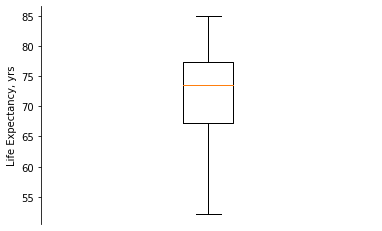

In [80]:
# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
life_expect_boxplot = plt.boxplot(life_expect)
plt.ylabel('Life Expectancy, yrs')
plt.xticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Measure correlation between Life Expectancy and Urban Population %

In [81]:
urban_pop = country_doctors_total_avg["Urban population"]

# Calculate the correlation coefficient and a linear regression model 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(urban_pop, life_expect)
regress_values = urban_pop * slope + intercept

# Print summary
st.linregress(urban_pop, life_expect)

LinregressResult(slope=0.20960452658895146, intercept=60.13577971371717, rvalue=0.6177675233644961, pvalue=2.7918422048609635e-27, stderr=0.017080576290189883, intercept_stderr=1.0555839781164265)

In [82]:
# Calculate Pearson coefficient
correlation = st.pearsonr(urban_pop,life_expect)

# Print summary
correlation

PearsonRResult(statistic=0.6177675233644959, pvalue=2.79184220486113e-27)

Correlation between Life Expectancy and size of Urban Population is 0.38
Linear regression equation: y=0.21 * x + 60.14


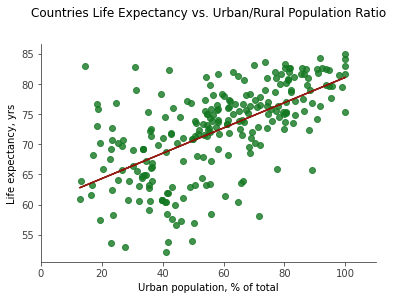

<Figure size 1080x1080 with 0 Axes>

In [83]:
# Generate a scatter plot of urban/rural ratio vs. average life expectancy across analyzed years
urban_life_expect = plt.scatter(urban_pop,life_expect,c='#147822', alpha=0.8)

# Adjust chart properties
ax = plt.gca()
ax.set_title("Countries Life Expectancy vs. Urban/Rural Population Ratio", fontsize=12, y=1.1)
ax.set_xlabel("Urban population, % of total", fontsize=10)
ax.set_xlim(0,110)
ax.set_ylabel("Life expectancy, yrs", fontsize=10)
plt.figure(figsize=(15, 15)) 
# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Adjust axis and ticks colour
ax.spines['bottom'].set_color('#404040')
ax.spines['left'].set_color('#404040')
ax.tick_params(axis='both', colors='#404040', labelsize=10)

# Plot regression line
ax.plot(urban_pop,regress_values, c='#8f130a', alpha=0.95)

# Print summary
print(f"Correlation between Life Expectancy and size of Urban Population is {round(rvalue**2,2)}") # Moderate correlation
print(f"Linear regression equation: y={round(slope,2)} * x + {round(intercept,2)}")

# Save the graph as an image 
plt.savefig('Images/urban_pop_fig1.png')

# Display the graph
plt.show()

### Identify countries that are not following the overall trend

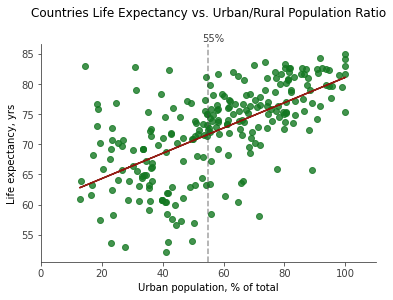

<Figure size 1080x1080 with 0 Axes>

In [84]:
# Generate a scatter plot of urban/rural ratio vs. average life expectancy across analyzed years
urban_pop = country_doctors_total_avg["Urban population"]

# Plot data
urban_life_expect = plt.scatter(urban_pop,life_expect,c='#147822', alpha=0.8)

# Adjust chart properties
ax = plt.gca()
ax.set_title("Countries Life Expectancy vs. Urban/Rural Population Ratio", fontsize=12, y=1.1)
ax.set_xlabel("Urban population, % of total", fontsize=10)
ax.set_xlim(0,110)
ax.set_ylabel("Life expectancy, yrs", fontsize=10)
plt.figure(figsize=(15, 15)) 
# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Adjust axis and ticks colour
ax.spines['bottom'].set_color('#404040')
ax.spines['left'].set_color('#404040')
ax.tick_params(axis='both', colors='#404040', labelsize=10)

# Calculate the correlation coefficient and a linear regression model 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(urban_pop, life_expect)
regress_values = urban_pop * slope + intercept

# Plot regression line
ax.plot(urban_pop,regress_values, c='#8f130a', alpha=0.95)

# Draw a line at 55% Urban Population
ax.axvline(x=55, color='#404040', linestyle='--', alpha=0.5)
# Add a label to the vertical lines
ax.text(53, 87, '55%', color='#404040')

# Save the graph as an image 
plt.savefig('Images/urban_pop_fig2.png')

# Display the graph
plt.show()

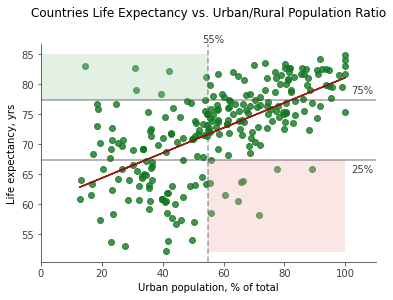

<Figure size 1080x1080 with 0 Axes>

In [85]:
# Generate a scatter plot of urban/rural ratio vs. average life expectancy across analyzed years
urban_pop = country_doctors_total_avg["Urban population"]

# Plot data
urban_life_expect = plt.scatter(urban_pop,life_expect,c='#147822', alpha=0.8)

# Adjust chart properties
ax = plt.gca()
ax.set_title("Countries Life Expectancy vs. Urban/Rural Population Ratio", fontsize=12, y=1.1)
ax.set_xlabel("Urban population, % of total", fontsize=10)
ax.set_xlim(0,110)
ax.set_ylabel("Life expectancy, yrs", fontsize=10)
plt.figure(figsize=(15, 15)) 
# Remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Adjust axis and ticks colour
ax.spines['bottom'].set_color('#404040')
ax.spines['left'].set_color('#404040')
ax.tick_params(axis='both', colors='#404040', labelsize=10)

# Calculate the correlation coefficient and a linear regression model 
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(urban_pop, life_expect)
regress_values = urban_pop * slope + intercept

# Plot regression line
ax.plot(urban_pop,regress_values, c='#8f130a', alpha=0.95)

# Draw a line at 55% Urban Population
ax.axvline(x=55, color='#404040', linestyle='--', alpha=0.5)
# Add a label to the vertical lines
ax.text(53, 87, '55%', color='#404040')

# Draw a line at Q1 and Q3 for Life Expectancy
ax.axhline(y=lowerq, color='#404040', alpha=0.5)
ax.axhline(y=upperq, color='#404040', alpha=0.5)
# Add a labels for horizontal lines
ax.text(102, lowerq-2, '25%', color='#404040')
ax.text(102, upperq+1, '75%', color='#404040')

# Color the plot chart area for countries that are falling out of overall trend
# Define the x and y coordinates for the upper polygon
x_coords_up = [0, 55, 55, 0]
y_coords_up = [upperq, upperq, life_expect_max, life_expect_max]
# Colour the 1st poligon based on the specified coordinates
ax.fill(x_coords_up, y_coords_up,'#a5d1ac', alpha=0.3)

# Define the x and y coordinates for the upper polygon
x_coords_low = [55, 100, 100, 55]
y_coords_low = [life_expect_min, life_expect_min, lowerq, lowerq]
# Colour the 1st poligon based on the specified coordinates
ax.fill(x_coords_low, y_coords_low,'#f5aeae', alpha=0.3)

# Save the graph as an image 
plt.savefig('Images/urban_pop_fig3.png')

# Display the graph
plt.show()

In [86]:
# Display countries with life expectancy over Q3 and Urban Population under 55%
life_expect_over_q3 = country_doctors_total_avg[country_doctors_total_avg["Life expectancy total population"] >= upperq]
life_expect_over_q3_urb = life_expect_over_q3[life_expect_over_q3["Urban population"] <= 55]

# Sort the list
life_expect_over_q3_df = life_expect_over_q3_urb.loc[:, ['Country', 'Urban population', 'Life expectancy total population']].sort_values(by= "Urban population").reset_index(drop = True)

life_expect_over_q3_df

,Country,Urban population,Life expectancy total population
0,Liechtenstein,14.3260,83.015326
1,Channel Islands,30.9302,82.750814
2,Barbados,31.1812,79.000502
3,Maldives,39.3818,78.296209
4,Faroe Islands,41.9236,82.263520
5,Slovenia,54.2874,81.209604


In [87]:
# Display countries with life expectancy below Q1 and Urban Population above 55%
life_expect_under_q1 = country_doctors_total_avg[country_doctors_total_avg["Life expectancy total population"] <= lowerq]
life_expect_under_q1_urb = life_expect_under_q1[life_expect_under_q1 ["Urban population"] >= 55]

# Sort the list
life_expect_under_q1_df = life_expect_under_q1_urb.loc[:, ['Country', 'Urban population', 'Life expectancy total population']].sort_values(by= "Urban population").reset_index(drop = True)

life_expect_under_q1_df

,Country,Urban population,Life expectancy total population
0,Ghana,55.4018,63.452269
1,Cameroon,55.7752,58.482236
2,"Gambia, The",60.5892,61.492737
3,Angola,64.8250,60.446212
4,South Africa,65.8460,63.639464
5,"Congo, Rep.",66.4584,63.873133
6,Equatorial Guinea,71.6340,58.089527
7,Djibouti,77.6570,65.885708
8,Gabon,88.9528,65.762798


### T-test
H0 = Life Expectancy for countries with Urban population < 55% is no different than Life Expectancy for countries with Urban population >= 55%.

H1 = Life expectancy for countries with Urban population < 55% is lower than for countries with Urban population >= 55%.


### Assumptions

1. Data is normally distributed
2. Data is independent
3. Data is homogenous (The standard deviations are roughly equal)

### Results
There is statistical evidence that H0 can be rejected with the confidence level of 95%, meaning that Life expectancy for countries where Urban population is lower than 55% is not as high as for countries with Urban population higher or equal to 55%.

In [88]:
# Run T-test for the 2 groups of countries
population1 = country_doctors_total_avg[country_doctors_total_avg["Urban population"]<55]["Life expectancy total population"]
population2 = country_doctors_total_avg[country_doctors_total_avg["Urban population"]>=55]["Life expectancy total population"]

(statistic, pvalue_2) = st.ttest_ind(population1, population2, equal_var=False)

# Print the summary
st.ttest_ind(population1, population2, equal_var=False)

Ttest_indResult(statistic=-10.782843029791302, pvalue=8.933679816645654e-22)

In [89]:
# Calculate one-tailed p-value
pvalue_one_tail = pvalue_2 / 2

pvalue_one_tail

4.466839908322827e-22

In [90]:
# Calculate median values for 2 populations
median_less55 = population1.median()
median_over55 = population2.median()

print(f'Median of the population1 (urban population < 55%): {round(median_less55,0)}, population size: {len(population1)}')
print(f'Median of the population2 (urban population >= 55%): {round(median_over55,0)}, population size: {len(population2)}')

Median of the population1 (urban population < 55%): 68.0, population size: 111
Median of the population2 (urban population >= 55%): 76.0, population size: 135


In [91]:
# Calculate mean values for 2 populations
mean_less55 = population1.mean()
mean_over55 = population2.mean()

print(f'Mean of the population1 (urban population < 55%): {round(mean_less55,0)}, population size: {len(population1)}')
print(f'Mean of the population2 (urban population >= 55%): {round(mean_over55,0)}, population size: {len(population2)}')

Mean of the population1 (urban population < 55%): 67.0, population size: 111
Mean of the population2 (urban population >= 55%): 76.0, population size: 135


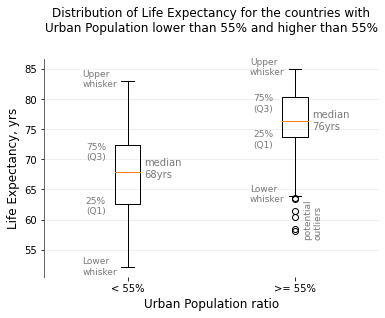

In [92]:
# Plot boxplots
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Life Expectancy, yrs', fontsize = 12)
ax1.set_xlabel('Urban Population ratio', fontsize=12)
ax1.set_title('Distribution of Life Expectancy for the countries with\nUrban Population lower than 55% and higher than 55%', fontsize=12, y=1.1)
ax1.spines['left'].set_color('#404040')
ax1.boxplot([population1, population2], showmeans=False, labels = ["< 55%", ">= 55%"])
ax1.yaxis.grid(True, color='#404040',alpha=0.1)

# Add a labels
ax1.text(0.73, 82, 'Upper\nwhisker', color='#404040',fontsize=9,alpha=0.7)
ax1.text(1.73, 84, 'Upper\nwhisker', color='#404040',fontsize=9,alpha=0.7)
ax1.text(0.73, 51, 'Lower\nwhisker', color='#404040',fontsize=9,alpha=0.7)
ax1.text(1.73, 63, 'Lower\nwhisker', color='#404040',fontsize=9,alpha=0.7)
ax1.text(0.75, 61, '25%\n(Q1)', color='#404040',fontsize=9,alpha=0.7)
ax1.text(1.75, 72, '25%\n(Q1)', color='#404040',fontsize=9,alpha=0.7)
ax1.text(0.75, 70, '75%\n(Q3)', color='#404040',fontsize=9,alpha=0.7)
ax1.text(1.75, 78, '75%\n(Q3)', color='#404040',fontsize=9,alpha=0.7)
ax1.text(1.1, 67, f'median\n{round(median_less55,)}yrs', color='#404040',fontsize=10,alpha=0.7)
ax1.text(2.1, 75, f'median\n{round(median_over55,)}yrs', color='#404040',fontsize=10,alpha=0.7)
ax1.text(2.05, 57, 'potential\noutliers', color='#404040',fontsize=9,rotation=90,alpha=0.7)

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Save the graph as an image 
plt.savefig('Images/urban_pop_fig4.png')

# Display the graph
plt.show()

### Plot Life Expectancy and Urban Population ratio info by Countries on a map

In [93]:
# Create a DataFrame to plot information on a map
life_expect_map = country_doctors_total_avg_filtered.loc[:,["Country", 
                                                            "Urban population", 
                                                            "Life expectancy total population",
                                                            "Medical doctors (number)"
                                                            ]
                                                        ]

# Configure Data Frame
life_expect_map = life_expect_map.rename(columns={'Urban population': 'Urban population, % of total', 
                                                'Life expectancy total population': 'Life expectancy, yrs',
                                                'Medical doctors (number)': 'Medical doctors, #'})

life_expect_map["Urban population, % of total"] = life_expect_map["Urban population, % of total"].round(2)
life_expect_map["Life expectancy, yrs"] = life_expect_map["Life expectancy, yrs"].astype(int)
life_expect_map["Medical doctors, #"] = life_expect_map["Medical doctors, #"].astype(int)

# Merge the dataset with coordinates dataset
coord_path = "Data/world_latitude_longitude.csv"
coord_data = pd.read_csv(coord_path)
coord_data.rename(columns={'country': 'Country'}, inplace=True)

life_expect_map_coord = pd.merge(life_expect_map, coord_data, on=["Country"], how = "left")
life_expect_map_long_lat = life_expect_map_coord[["Country","Urban population, % of total","Life expectancy, yrs", "Medical doctors, #","latitude","longitude"]]

# Drop null values
life_expect_map_long_lat = life_expect_map_long_lat.dropna(subset=["latitude","longitude"]).reset_index(drop=True)

life_expect_map_long_lat


,Country,"Urban population, % of total","Life expectancy, yrs","Medical doctors, #",latitude,longitude
0,Afghanistan,25.26,64,9500,33.939110,67.709953
1,Albania,59.36,78,4826,41.153332,20.168331
2,Algeria,72.04,76,73456,28.033886,1.659626
3,Angola,64.82,60,6496,-11.202692,17.873887
4,Antigua and Barbuda,24.73,76,264,17.060816,-61.796428
...,...,...,...,...,...,...
136,United Arab Emirates,86.24,77,23108,23.424076,53.847818
137,Uruguay,95.24,77,15260,-32.522779,-55.765835
138,Vanuatu,25.17,70,46,-15.376706,166.959158
139,Zambia,42.98,62,1770,-13.133897,27.849332


In [94]:
# Plot the information on the map
map_life_expect_urban = life_expect_map_long_lat.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "EsriTerrain",
    frame_width = 1000,
    frame_height = 800,
    scale = 1.5,
    size = "Urban population, % of total",
    color = "Life expectancy, yrs",
    cmap= 'RdYlGn',
    hover_cols = ["Country", 
                "Urban population, % of total", 
                "Life expectancy, yrs", 
                "Medical doctors, #"],
    alpha = 0.7,
    clim=(lowerq,upperq), 
    )

# Add title 
map_with_title = map_life_expect_urban.opts(title='Life Expectancy vs Urban Population ratio (141 countries)')

# Display the map plot
map_with_title

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (Life expectancy, yrs,Urban population, % of total,Country,Medical doctors, #)